## **GOOGLE STOCKS ANALYSIS + PREDICTION USING LSTM**

In [5]:
import pandas as pd

# Load the uploaded CSV file to inspect its structure
file_path = '/content/Data.csv'
data = pd.read_csv(file_path)

# Display the first few rows and the structure of the dataset
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      234 non-null    object
 1   Adj Close  234 non-null    object
 2   Close      234 non-null    object
 3   High       234 non-null    object
 4   Low        234 non-null    object
 5   Open       234 non-null    object
 6   Volume     234 non-null    object
dtypes: object(7)
memory usage: 12.9+ KB


(        Price           Adj Close               Close                High  \
 0      Ticker                GOOG                GOOG                GOOG   
 1  2024-01-02  139.21810913085938  139.55999755859375  140.61500549316406   
 2  2024-01-03  140.01614379882812  140.36000061035156  141.08999633789062   
 3  2024-01-04   137.7018280029297   138.0399932861328  140.63499450683594   
 4  2024-01-05   137.0534210205078  137.38999938964844  138.80999755859375   
 
                   Low                Open    Volume  
 0                GOOG                GOOG      GOOG  
 1  137.74000549316406  139.60000610351562  20071900  
 2  138.42999267578125  138.60000610351562  18974300  
 3  138.00999450683594  139.85000610351562  18253300  
 4  136.85000610351562   138.3520050048828  15433200  ,
 None)

In [6]:
# Reload the dataset, skipping the first row
data = pd.read_csv(file_path, skiprows=1)

# Rename columns for better clarity
data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Convert columns to numeric where applicable
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
numeric_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop any rows with invalid dates or NaN values
data = data.dropna()

# Display the cleaned dataset structure and first few rows
data.info(), data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       233 non-null    datetime64[ns]
 1   Adj Close  233 non-null    float64       
 2   Close      233 non-null    float64       
 3   High       233 non-null    float64       
 4   Low        233 non-null    float64       
 5   Open       233 non-null    float64       
 6   Volume     233 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 12.9 KB


(None,
         Date   Adj Close       Close        High         Low        Open  \
 0 2024-01-02  139.218109  139.559998  140.615005  137.740005  139.600006   
 1 2024-01-03  140.016144  140.360001  141.089996  138.429993  138.600006   
 2 2024-01-04  137.701828  138.039993  140.634995  138.009995  139.850006   
 3 2024-01-05  137.053421  137.389999  138.809998  136.850006  138.352005   
 4 2024-01-08  140.185715  140.529999  140.639999  137.880005  138.000000   
 
      Volume  
 0  20071900  
 1  18974300  
 2  18253300  
 3  15433200  
 4  17645300  )

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare features and target variable for forecasting
data['Target'] = data['Adj Close'].shift(-1)  # Predict next day's Adj Close
data = data.dropna()  # Remove rows with NaN values after shifting

X = data[['Adj Close']]  # Features (current day's Adj Close)
y = data['Target']       # Target (next day's Adj Close)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display the RMSE and some sample predictions
rmse, pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head()


(2.6125408214990276,
          Actual   Predicted
 185  165.289993  163.900922
 186  167.190002  165.327841
 187  168.419998  167.184811
 188  167.309998  168.386945
 189  167.210007  167.302088)

In [8]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Scale the data using Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Adj Close']])

# Create sequences for LSTM
sequence_length = 10  # Use the past 10 days to predict the next day
X_lstm, y_lstm = [], []

for i in range(sequence_length, len(scaled_data)):
    X_lstm.append(scaled_data[i-sequence_length:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split data into training and testing sets
split = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

# Reshape input data for LSTM (samples, timesteps, features)
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test_lstm)
predictions = scaler.inverse_transform(predictions)  # Inverse scaling to original values

# Inverse transform actual test values for comparison
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Display some predictions vs actual values
pd.DataFrame({'Actual': y_test_lstm_rescaled.flatten(), 'Predicted': predictions.flatten()}).head()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2499
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0419 
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0398
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0136
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0190
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0097
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0090
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0078
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0082
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━

,Actual,Predicted
0,167.190002,162.982376
1,168.419998,163.601059
2,167.309998,164.264725
3,167.210007,164.898514
4,168.559998,165.372665


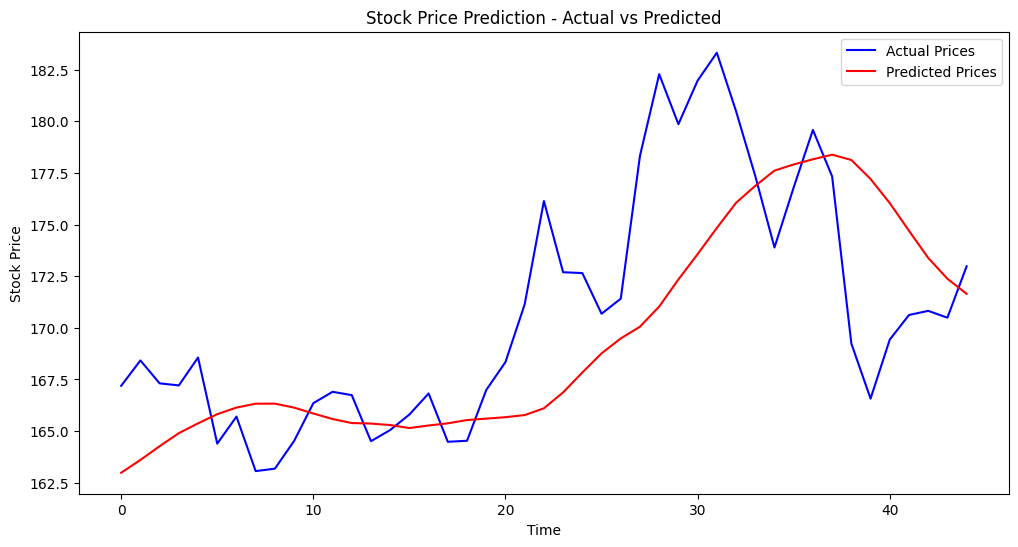

In [17]:
# Assuming `y_test_lstm_rescaled` (actual values) and `predictions` (predicted values) are available

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm_rescaled.flatten(), label='Actual Prices', color='blue')
plt.plot(predictions.flatten(), label='Predicted Prices', color='red')
plt.title('Stock Price Prediction - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [18]:
# What was the change in price of the stock over time?
data['Price Change'] = data['Close'].diff()
data['Price Change'].head()


,Price Change
0,NaN
1,0.800003
2,-2.320007
3,-0.649994
4,3.139999


In [15]:
# What was the daily return of the stock on average?
data['Daily Return'] = data['Close'].pct_change()
average_daily_return = data['Daily Return'].mean()
average_daily_return


0.0010733266975463472

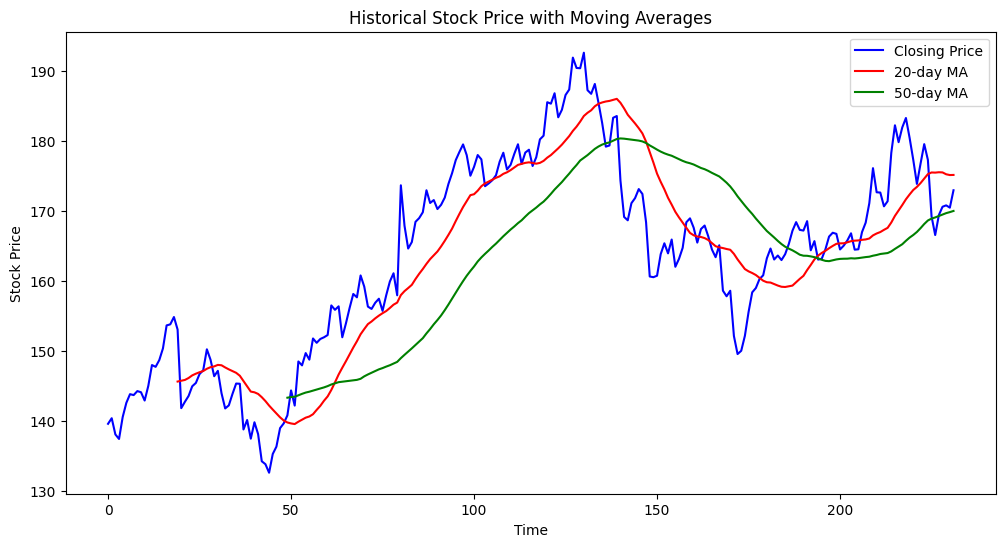

In [14]:
#  The moving average of the various stocks based on LSTM model
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Closing Price', color='blue')
plt.plot(data['Close'].rolling(window=20).mean(), label='20-day MA', color='red')
plt.plot(data['Close'].rolling(window=50).mean(), label='50-day MA', color='green')
plt.title('Historical Stock Price with Moving Averages')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

